# Coursera Kaggle Final Project - Data Science Sales Prediction Competition

***

This challenge serves as final project for the "How to win a data science competition" Coursera course.
the link to the contest can be found here: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/

In this competition, it will be worked with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

Will be predicted total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.


## About Dataset


<p><strong>sales_train.csv --></strong> The training set. Daily historical data from January 2013 to October 2015.<br>
<strong>test.csv --></strong>The test set. Data to forecast the sales for these shops and products for November 2015. The range of the target variable is [0-20]</p>

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
start_time = time.time()

import gc
from tqdm import tqdm
import pickle

pd.set_option('display.max_rows', 99)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')

SEED = 0
Validation = False

Loading dataset

In [2]:
df = pd.read_csv("sales_train.csv")
test_df = pd.read_csv("test.csv")
df_items = pd.read_csv("items.csv")

In [3]:
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


First glimpse of the data

In [4]:
print("__________INFORMATION__________")
print(df.info())
print("__________MISSING VALUES_________")
print(df.isnull().sum())
print("__________NULL VALUES__________")
print(df.isna().sum())
print("__________SHAPE__________")
print(df.shape)
print("__________FIRST ROWS__________")
df.head(10)

__________INFORMATION__________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
__________MISSING VALUES_________
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
__________NULL VALUES__________
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
__________SHAPE__________
(2935849, 6)
__________FIRST ROWS__________


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [5]:
#droping matching duplicates
df = df.merge(test_df[['shop_id']].drop_duplicates(), how = 'inner')

In [6]:
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,10.01.2013,0,59,22151,399.0,1.0
2,04.01.2013,0,59,5603,699.0,1.0
3,19.01.2013,0,59,5587,199.0,2.0
4,31.01.2013,0,59,5613,5571.0,1.0
...,...,...,...,...,...,...
2413241,30.10.2015,33,36,20231,169.0,1.0
2413242,18.10.2015,33,36,20334,1949.0,1.0
2413243,31.10.2015,33,36,20339,1549.0,1.0
2413244,31.10.2015,33,36,20352,1549.0,1.0


## Preprocessing

Turning date column format into date_type and splitting into year, month, day 

In [7]:
df['date'] = pd.to_datetime(df['date'], format = '%d.%m.%Y')
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
print(df.shape)
df.head(5)

(2413246, 9)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-01-02,0,59,22154,999.0,1.0,2,1,2013
1,2013-01-10,0,59,22151,399.0,1.0,10,1,2013
2,2013-01-04,0,59,5603,699.0,1.0,4,1,2013
3,2013-01-19,0,59,5587,199.0,2.0,19,1,2013
4,2013-01-31,0,59,5613,5571.0,1.0,31,1,2013


There are other complementary tables for the project, such as item categories, item names and shope names (which won't be of any help here). For the purpose of the project we will only include the item category, which can be extracted from the file items.csv

## EDA - Viz

First we are going to explore the different scatter plots for the main features 

<function matplotlib.pyplot.show(*args, **kw)>

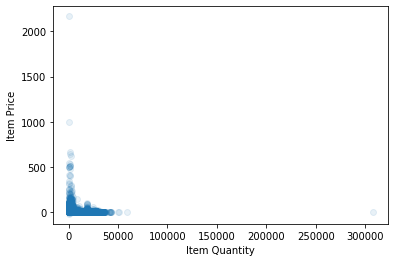

In [8]:
plt.scatter(df["item_price"],df["item_cnt_day"], alpha=0.1)
plt.xlabel("Item Quantity")
plt.ylabel("Item Price")
#plt.xscale('log')
plt.show


{'whiskers': [<matplotlib.lines.Line2D at 0x20243e59d48>,
 'caps': [<matplotlib.lines.Line2D at 0x20243e60dc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x20243e59b88>],
 'medians': [<matplotlib.lines.Line2D at 0x20243e65d48>],
 'fliers': [<matplotlib.lines.Line2D at 0x20243e6ac08>],
 'means': []}

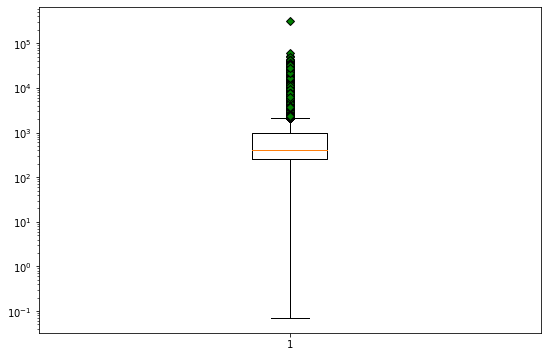

In [9]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig1 = plt.figure(1, figsize=(9, 6))
ax1 = fig1.add_subplot(111)
ax1.set_yscale("log")
ax1.boxplot(df.item_price, flierprops=green_diamond)


{'whiskers': [<matplotlib.lines.Line2D at 0x20243de76c8>,
 'caps': [<matplotlib.lines.Line2D at 0x202437e9a88>,
 'boxes': [<matplotlib.lines.Line2D at 0x20243e11e48>],
 'medians': [<matplotlib.lines.Line2D at 0x20243db7748>],
 'fliers': [<matplotlib.lines.Line2D at 0x20243d8e108>],
 'means': []}

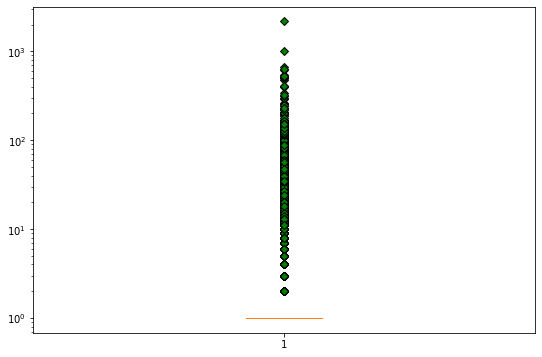

In [10]:
fig2 = plt.figure(1, figsize=(9, 6))
ax2 = fig2.add_subplot(111)
ax2.set_yscale("log")
ax2.boxplot(df.item_cnt_day, flierprops=green_diamond)

From the boxplots above, we can see some outliers that can make our model representation to overfit, therefore, for this analysis we are going to remove them:

In [11]:
df = df[df['item_price']<100000]
df = df[df['item_cnt_day']<1000]
df[['item_price','item_cnt_day']].describe()

,item_price,item_cnt_day
count,2.413243e+06,2.413243e+06
mean,9.050433e+02,1.237853e+00
std,1.747847e+03,2.259161e+00
min,7.000000e-02,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,5.920000e+04,6.690000e+02


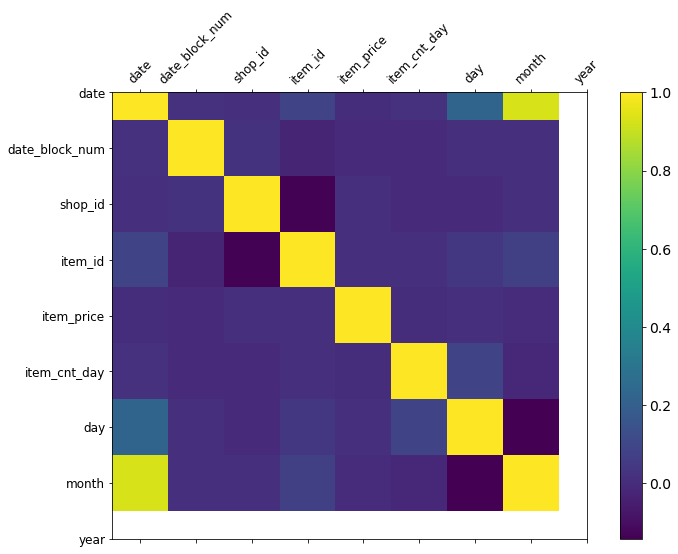

In [12]:
fig3 = plt.figure(figsize=(12, 8))
plt.matshow(df.corr(), fignum=fig3.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);

From the correlation matrix we can observe that features shop_id & year are some how correlated

### Tips from instructors #1:

A good exercise is to reproduce previous_value_benchmark. As the name suggest - in this benchmark for the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference.

## Data Aggregation

We need to create a dataframe (grid) of all the combinations of unique (disctinct) date_block_num, store_id and item_id.

In [13]:
from itertools import product
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in df['date_block_num'].unique():
    cur_shops = df.loc[df['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = df.loc[df['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid
print('%0.2f min: Finish creating the grid'%((time.time() - start_time)/60))

0.49 min: Finish creating the grid


In [14]:
# Generating the target variable -grouped counts per shop, item & month- and only ranging target from 0 to 20
df['item_cnt_day'] = df['item_cnt_day'].clip(0,20)
gb_cnt = df.groupby(index_cols)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'item_cnt_month'})
gb_cnt['item_cnt_month'] = gb_cnt['item_cnt_month'].clip(0,20).astype(np.int)

In [15]:
# join aggregated data to the grid
train = pd.merge(grid,gb_cnt,how='left',on=index_cols).fillna(0)
train['item_cnt_month'] = train['item_cnt_month'].astype(int)
print('%0.2f min: Finish creating the grid'%((time.time() - start_time)/60))

0.63 min: Finish creating the grid


### Downcasting DataFrame

this method is done in order to save memory

In [16]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast_dtypes(train)

# sorting value

train.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [17]:
# Joining item category to the DFs
train = train.merge(df_items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')
test_df = test_df.merge(df_items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')

In [18]:
del grid, gb_cnt
gc.collect()

3641

You can get a rather good score after creating some lag-based features like in advice from previous week and feeding them into gradient boosted trees model.

Apart from item/shop pair lags you can try adding lagged values of total shop or total item sales (which are essentially mean-encodings). All of that is going to add some new information.

## Feature Engineering

### - Target Encodings

First we are going to apply the learnings from the feature engineering class of the course, thus, we will apply first some target encodings: MEAN for item_price & item_cnt_day and SUM for item_cnt_day

In [19]:
# Adding item/shop pair mean-encodings -----------------------------------------

# For Trainset
print('%0.2f min: Start adding mean-encoding for item_cnt_month'%((time.time() - start_time)/60))
Target = 'item_cnt_month'
global_mean =  train[Target].mean()
y_tr = train[Target].values

mean_encoded_col = ['shop_id', 'item_id', 'item_category_id']

for col in tqdm(mean_encoded_col):

    col_tr = train[[col] + [Target]]
    corrcoefs = pd.DataFrame(columns = ['Cor'])

    # Mean encodings - KFold scheme
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = 5, shuffle = False, random_state = SEED)
    col_tr[col + '_cnt_month_mean_Kfold'] = global_mean
    for tr_ind, val_ind in kf.split(col_tr):
        X_tr, X_val = col_tr.iloc[tr_ind], col_tr.iloc[val_ind]
        means = X_val[col].map(X_tr.groupby(col)[Target].mean())
        X_val[col + '_cnt_month_mean_Kfold'] = means
        col_tr.iloc[val_ind] = X_val
    col_tr.fillna(global_mean, inplace = True)
    corrcoefs.loc[col + '_cnt_month_mean_Kfold'] = np.corrcoef(y_tr, col_tr[col + '_cnt_month_mean_Kfold'])[0][1]

    # Mean encodings - Leave-one-out scheme
    item_id_target_sum = col_tr.groupby(col)[Target].sum()
    item_id_target_count = col_tr.groupby(col)[Target].count()
    col_tr[col + '_cnt_month_sum'] = col_tr[col].map(item_id_target_sum)
    col_tr[col + '_cnt_month_count'] = col_tr[col].map(item_id_target_count)
    col_tr[col + '_target_mean_LOO'] = (col_tr[col + '_cnt_month_sum'] - col_tr[Target]) / (col_tr[col + '_cnt_month_count'] - 1)
    col_tr.fillna(global_mean, inplace = True)
    corrcoefs.loc[col + '_target_mean_LOO'] = np.corrcoef(y_tr, col_tr[col + '_target_mean_LOO'])[0][1]

    # Mean encodings - Smoothing
    item_id_target_mean = col_tr.groupby(col)[Target].mean()
    item_id_target_count = col_tr.groupby(col)[Target].count()
    col_tr[col + '_cnt_month_mean'] = col_tr[col].map(item_id_target_mean)
    col_tr[col + '_cnt_month_count'] = col_tr[col].map(item_id_target_count)
    alpha = 100
    col_tr[col + '_cnt_month_mean_Smooth'] = (col_tr[col + '_cnt_month_mean'] *  col_tr[col + '_cnt_month_count'] + global_mean * alpha) / (alpha + col_tr[col + '_cnt_month_count'])
    col_tr[col + '_cnt_month_mean_Smooth'].fillna(global_mean, inplace=True)
    corrcoefs.loc[col + '_cnt_month_mean_Smooth'] = np.corrcoef(y_tr, col_tr[col + '_cnt_month_mean_Smooth'])[0][1]

    # 3.1.4 Mean encodings - Expanding mean scheme
    cumsum = col_tr.groupby(col)[Target].cumsum() - col_tr[Target]
    sumcnt = col_tr.groupby(col).cumcount()
    col_tr[col + '_cnt_month_mean_Expanding'] = cumsum / sumcnt
    col_tr[col + '_cnt_month_mean_Expanding'].fillna(global_mean, inplace=True)
    corrcoefs.loc[col + '_cnt_month_mean_Expanding'] = np.corrcoef(y_tr, col_tr[col + '_cnt_month_mean_Expanding'])[0][1]
    train = pd.concat([train, col_tr[corrcoefs['Cor'].idxmax()]], axis = 1)
    print(corrcoefs.sort_values('Cor'))
    print('%0.2f min: Finish encoding %s'%((time.time() - start_time)/60, col))

print('%0.2f min: Finish adding mean-encoding'%((time.time() - start_time)/60))



0.74 min: Start adding mean-encoding for item_cnt_month


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

                                       Cor
shop_id_cnt_month_mean_Kfold      0.173375
shop_id_target_mean_LOO           0.175551
shop_id_cnt_month_mean_Smooth     0.175576
shop_id_cnt_month_mean_Expanding  0.175750
0.96 min: Finish encoding shop_id


 33%|████████████████████████████                                                        | 1/3 [00:13<00:26, 13.13s/it]

                                       Cor
item_id_cnt_month_mean_Kfold      0.315800
item_id_cnt_month_mean_Smooth     0.479793
item_id_target_mean_LOO           0.481889
item_id_cnt_month_mean_Expanding  0.565619
1.16 min: Finish encoding item_id


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:25<00:12, 12.89s/it]

                                                Cor
item_category_id_cnt_month_mean_Kfold      0.273997
item_category_id_cnt_month_mean_Smooth     0.292659
item_category_id_target_mean_LOO           0.292705
item_category_id_cnt_month_mean_Expanding  0.296038
1.35 min: Finish encoding item_category_id


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:36<00:00, 12.22s/it]


1.35 min: Finish adding mean-encoding


In [20]:
train

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,shop_id_cnt_month_mean_Expanding,item_id_cnt_month_mean_Expanding,item_category_id_cnt_month_mean_Expanding
0,2,19,0,0,40,0.310683,0.310683,0.310683
1,2,27,0,1,19,0.000000,0.310683,0.310683
2,2,28,0,0,30,0.500000,0.310683,0.310683
3,2,29,0,0,23,0.333333,0.310683,0.310683
4,2,32,0,0,40,0.250000,0.310683,0.000000
...,...,...,...,...,...,...,...,...
8598001,59,22162,33,0,40,0.208937,1.386308,0.253682
8598002,59,22163,33,0,40,0.208936,0.601626,0.253682
8598003,59,22164,33,0,37,0.208935,1.141304,0.185897
8598004,59,22166,33,0,54,0.208934,0.318363,0.172386


### - Lag Features

In [21]:
# Combine trainset and testset -----------------------------------------

if Validation == False:
    test_df['date_block_num'] = 34
    all_data = pd.concat([train, test_df], axis = 0)
    all_data = all_data.drop(columns = ['ID'])
else:
    all_data = train

del train, col_tr
gc.collect()

all_data = downcast_dtypes(all_data)

In [22]:
# Creating item/shop pair lags lag-based features ----------------------------

index_cols = ['shop_id', 'item_id', 'item_category_id', 'date_block_num']
cols_to_rename = list(all_data.columns.difference(index_cols))
print(cols_to_rename)
shift_range = [1, 2, 3, 4, 11, 12] # Using last 4 months as lags + last 2 months from prev year

for month_shift in tqdm(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift
gc.collect()

all_data = all_data[all_data['date_block_num'] >= 12] # Don't use old data from year 2013
lag_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
all_data = downcast_dtypes(all_data)
print('%0.2f min: Finish generating lag features'%((time.time() - start_time)/60))


['item_category_id_cnt_month_mean_Expanding', 'item_cnt_month', 'item_id_cnt_month_mean_Expanding', 'shop_id_cnt_month_mean_Expanding']


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:02<00:00, 10.43s/it]


2.54 min: Finish generating lag features


In [23]:
all_data

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,shop_id_cnt_month_mean_Expanding,item_id_cnt_month_mean_Expanding,item_category_id_cnt_month_mean_Expanding,item_category_id_cnt_month_mean_Expanding_lag_1,item_cnt_month_lag_1,item_id_cnt_month_mean_Expanding_lag_1,shop_id_cnt_month_mean_Expanding_lag_1,item_category_id_cnt_month_mean_Expanding_lag_2,item_cnt_month_lag_2,item_id_cnt_month_mean_Expanding_lag_2,shop_id_cnt_month_mean_Expanding_lag_2,item_category_id_cnt_month_mean_Expanding_lag_3,item_cnt_month_lag_3,item_id_cnt_month_mean_Expanding_lag_3,shop_id_cnt_month_mean_Expanding_lag_3,item_category_id_cnt_month_mean_Expanding_lag_4,item_cnt_month_lag_4,item_id_cnt_month_mean_Expanding_lag_4,shop_id_cnt_month_mean_Expanding_lag_4,item_category_id_cnt_month_mean_Expanding_lag_11,item_cnt_month_lag_11,item_id_cnt_month_mean_Expanding_lag_11,shop_id_cnt_month_mean_Expanding_lag_11,item_category_id_cnt_month_mean_Expanding_lag_12,item_cnt_month_lag_12,item_id_cnt_month_mean_Expanding_lag_12,shop_id_cnt_month_mean_Expanding_lag_12
3352896,2,30,12,0.0,40,0.104498,2.573201,0.256568,0.251934,0.0,2.731507,0.099465,0.251070,0.0,2.932927,0.098574,0.250921,0.0,3.237113,0.098741,0.252728,0.0,3.661417,0.096853,0.286124,0.0,0.310683,0.153303,0.000000,0.0,0.000000,0.000000
3352897,2,31,12,0.0,37,0.104497,1.821340,0.207911,0.204104,0.0,1.961644,0.099464,0.205840,0.0,2.121951,0.098573,0.208848,0.0,2.323024,0.098740,0.209553,0.0,2.590551,0.096851,0.208505,4.0,0.310683,0.153283,0.000000,0.0,0.000000,0.000000
3352898,2,32,12,1.0,40,0.104496,2.412844,0.256568,0.251934,0.0,2.447236,0.099462,0.251070,0.0,2.509695,0.098572,0.250921,0.0,2.654321,0.098738,0.252728,0.0,2.839721,0.096850,0.286120,0.0,5.333333,0.153795,0.000000,0.0,0.310683,0.250000
3352899,2,33,12,1.0,37,0.104505,0.793578,0.207910,0.204103,1.0,0.773869,0.099461,0.205840,2.0,0.819945,0.098571,0.208847,0.0,0.820988,0.098737,0.209552,0.0,0.797909,0.096848,0.208698,0.0,1.272727,0.153774,0.310683,1.0,0.310683,0.200000
3352900,2,34,12,0.0,40,0.104515,0.211009,0.256569,0.251934,0.0,0.221106,0.099472,0.251070,0.0,0.240997,0.098595,0.250921,0.0,0.262346,0.098735,0.252727,0.0,0.271777,0.096847,0.286116,0.0,0.242424,0.153754,0.000000,0.0,0.310683,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812201,45,18454,34,0.0,55,0.000000,0.000000,0.000000,0.230208,1.0,1.045662,0.179449,0.230833,0.0,1.151515,0.180668,0.231567,0.0,1.281690,0.181778,0.231938,0.0,1.423567,0.182946,0.231693,4.0,2.107143,0.193737,0.000000,0.0,0.000000,0.000000
8812202,45,16188,34,0.0,64,0.000000,0.000000,0.000000,0.308009,0.0,0.042857,0.179599,0.314892,0.0,0.071429,0.180940,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8812203,45,15757,34,0.0,55,0.000000,0.000000,0.000000,0.230211,0.0,0.226788,0.179682,0.230843,0.0,0.231918,0.180996,0.231576,0.0,0.235581,0.181990,0.231949,0.0,0.240336,0.183006,0.231701,0.0,0.247788,0.193585,0.228006,0.0,0.243337,0.192619
8812204,45,19648,34,0.0,40,0.000000,0.000000,0.000000,0.253942,0.0,0.111872,0.179316,0.254325,0.0,0.116162,0.180535,0.254929,0.0,0.121127,0.181664,0.255051,0.0,0.121019,0.182782,0.254004,0.0,0.250000,0.193625,0.000000,0.0,0.000000,0.000000


In [24]:
# Creating date features --------------------------------------------------------

dates_train = df[['date', 'date_block_num']].drop_duplicates()
dates_test = dates_train[dates_train['date_block_num'] == 34-12]
dates_test['date_block_num'] = 34
dates_test['date'] = dates_test['date'] + pd.DateOffset(years=1)

dates_all = pd.concat([dates_train, dates_test])
dates_all['dow'] = dates_all['date'].dt.dayofweek
dates_all['year'] = dates_all['date'].dt.year
dates_all['month'] = dates_all['date'].dt.month
dates_all = pd.get_dummies(dates_all, columns=['dow'])

dow_col = ['dow_' + str(x) for x in range(7)]
date_features = dates_all.groupby(['year', 'month', 'date_block_num'])[dow_col].agg('sum').reset_index()
date_features['days_of_month'] = date_features[dow_col].sum(axis=1)
date_features['year'] = date_features['year'] - 2013

date_features = date_features[['month', 'year', 'days_of_month', 'date_block_num']]
all_data = all_data.merge(date_features, on = 'date_block_num', how = 'left')
date_columns = date_features.columns.difference(set(index_cols))

print('%0.2f min: Finish getting date features'%((time.time() - start_time)/60))

2.59 min: Finish getting date features


In [25]:
# Scaling feature columns --------------------------------------------------------

from sklearn.preprocessing import StandardScaler
train = all_data[all_data['date_block_num']!= all_data['date_block_num'].max()]
test = all_data[all_data['date_block_num']== all_data['date_block_num'].max()]
sc = StandardScaler()

to_drop_cols = ['date_block_num']
feature_columns = list(set(lag_cols + index_cols + list(date_columns)).difference(to_drop_cols))

train[feature_columns] = sc.fit_transform(train[feature_columns])
test[feature_columns] = sc.transform(test[feature_columns])
all_data = pd.concat([train, test], axis = 0)
all_data = downcast_dtypes(all_data)

del train, test, df
gc.collect()

print('%0.2f min: Finish scaling features'%((time.time() - start_time)/60))



5.29 min: Finish scaling features


In [26]:
all_data

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,shop_id_cnt_month_mean_Expanding,item_id_cnt_month_mean_Expanding,item_category_id_cnt_month_mean_Expanding,item_category_id_cnt_month_mean_Expanding_lag_1,item_cnt_month_lag_1,item_id_cnt_month_mean_Expanding_lag_1,shop_id_cnt_month_mean_Expanding_lag_1,item_category_id_cnt_month_mean_Expanding_lag_2,item_cnt_month_lag_2,item_id_cnt_month_mean_Expanding_lag_2,shop_id_cnt_month_mean_Expanding_lag_2,item_category_id_cnt_month_mean_Expanding_lag_3,item_cnt_month_lag_3,item_id_cnt_month_mean_Expanding_lag_3,shop_id_cnt_month_mean_Expanding_lag_3,item_category_id_cnt_month_mean_Expanding_lag_4,item_cnt_month_lag_4,item_id_cnt_month_mean_Expanding_lag_4,shop_id_cnt_month_mean_Expanding_lag_4,item_category_id_cnt_month_mean_Expanding_lag_11,item_cnt_month_lag_11,item_id_cnt_month_mean_Expanding_lag_11,shop_id_cnt_month_mean_Expanding_lag_11,item_category_id_cnt_month_mean_Expanding_lag_12,item_cnt_month_lag_12,item_id_cnt_month_mean_Expanding_lag_12,shop_id_cnt_month_mean_Expanding_lag_12,month,year,days_of_month
0,-1.651720,-1.784869,12,0.0,-0.303427,0.104498,2.573201,0.256568,-0.078080,-0.244673,2.063134,-0.615930,-0.056446,-0.243253,2.227344,-0.580944,-0.033001,-0.240149,2.490486,-0.541951,-0.004740,-0.236934,2.865674,-0.513369,0.278211,-0.211104,-0.020321,-0.029796,-0.433504,-0.206551,-0.307650,-0.672567,-1.518597,-0.854240,0.660003
1,-1.651720,-1.784710,12,0.0,-0.493275,0.104497,1.821340,0.207911,-0.180811,-0.244673,1.357292,-0.615936,-0.154072,-0.243253,1.493087,-0.580949,-0.124886,-0.240149,1.670098,-0.541957,-0.100157,-0.236934,1.910096,-0.513376,0.080185,3.137038,-0.020321,-0.029885,-0.433504,-0.206551,-0.307650,-0.672567,-1.518597,-0.854240,0.660003
2,-1.651720,-1.784550,12,1.0,-0.303427,0.104496,2.412844,0.256568,-0.078080,-0.244673,1.802503,-0.615941,-0.056446,-0.243253,1.844151,-0.580955,-0.033001,-0.240149,1.967434,-0.541963,-0.004741,-0.236934,2.132441,-0.513382,0.278201,-0.211104,4.812187,-0.027644,-0.433504,-0.206551,-0.000489,0.419790,-1.518597,-0.854240,0.660003
3,-1.651720,-1.784391,12,1.0,-0.493275,0.104505,0.793578,0.207910,-0.180813,0.565292,0.268292,-0.615946,-0.154074,1.361513,0.314252,-0.580960,-0.124888,-0.240149,0.322032,-0.541969,-0.100159,-0.236934,0.310447,-0.513389,0.080678,-0.211104,0.905303,-0.027734,0.379962,0.642853,-0.000489,0.201318,-1.518597,-0.854240,0.660003
4,-1.651720,-1.784231,12,0.0,-0.303427,0.104515,0.211009,0.256569,-0.078081,-0.244673,-0.238505,-0.615900,-0.056447,-0.243253,-0.209927,-0.580855,-0.033002,-0.240149,-0.179345,-0.541975,-0.004742,-0.236934,-0.159043,-0.513396,0.278191,-0.211104,-0.085996,-0.027823,-0.433504,-0.206551,-0.000489,0.783909,-1.518597,-0.854240,0.660003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459305,0.758912,1.154222,34,0.0,0.645813,0.000000,0.000000,0.000000,-0.124745,0.565292,0.517482,-0.274865,-0.100127,-0.243253,0.614455,-0.231542,-0.075270,-0.240149,0.735509,-0.188668,-0.050686,-0.236934,0.868747,-0.146743,0.139343,3.137038,1.708130,0.147120,-0.433504,-0.206551,-0.307650,-0.672567,1.523812,1.170631,-0.456453
5459306,0.758912,0.792738,34,0.0,1.215356,0.000000,0.000000,0.000000,0.042360,-0.244673,-0.401930,-0.274225,0.081310,-0.243253,-0.363454,-0.230384,-0.580990,-0.240149,-0.414798,-0.962046,-0.563271,-0.236934,-0.401561,-0.925816,-0.451764,-0.211104,-0.319243,-0.700561,-0.433504,-0.206551,-0.307650,-0.672567,1.523812,1.170631,-0.456453
5459307,0.758912,0.723983,34,0.0,0.645813,0.000000,0.000000,0.000000,-0.124737,-0.244673,-0.233295,-0.273869,-0.100105,-0.243253,-0.218147,-0.230144,-0.075248,-0.240149,-0.203366,-0.187767,-0.050663,-0.236934,-0.187099,-0.146486,0.139363,-0.211104,-0.080835,0.146452,0.163488,-0.206551,-0.067072,0.169069,1.523812,1.170631,-0.456453
5459308,0.758912,1.344695,34,0.0,-0.303427,0.000000,0.000000,0.000000,-0.073768,-0.244673,-0.338655,-0.275432,-0.049422,-0.243253

## Train | Validation | Test split

In [27]:
# Saving `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts
dates = all_data['date_block_num']
last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)
print(feature_columns)

Test `date_block_num` is 34
['item_cnt_month_lag_1', 'month', 'item_cnt_month_lag_12', 'days_of_month', 'shop_id_cnt_month_mean_Expanding_lag_2', 'shop_id', 'item_id_cnt_month_mean_Expanding_lag_3', 'item_cnt_month_lag_4', 'item_id_cnt_month_mean_Expanding_lag_1', 'item_id_cnt_month_mean_Expanding_lag_11', 'item_cnt_month_lag_11', 'item_category_id_cnt_month_mean_Expanding_lag_2', 'item_category_id_cnt_month_mean_Expanding_lag_12', 'item_id_cnt_month_mean_Expanding_lag_2', 'shop_id_cnt_month_mean_Expanding_lag_3', 'shop_id_cnt_month_mean_Expanding_lag_1', 'item_id', 'item_id_cnt_month_mean_Expanding_lag_12', 'item_category_id', 'shop_id_cnt_month_mean_Expanding_lag_4', 'item_category_id_cnt_month_mean_Expanding_lag_1', 'item_cnt_month_lag_3', 'item_cnt_month_lag_2', 'item_category_id_cnt_month_mean_Expanding_lag_4', 'shop_id_cnt_month_mean_Expanding_lag_12', 'shop_id_cnt_month_mean_Expanding_lag_11', 'year', 'item_category_id_cnt_month_mean_Expanding_lag_11', 'item_id_cnt_month_mean_Ex

In [28]:
X_train = all_data[all_data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data.date_block_num < 33]['item_cnt_month']
X_valid = all_data[all_data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data.date_block_num == 33]['item_cnt_month']
X_test = all_data[all_data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

## Modelling

In [29]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression().fit(X_train, Y_train)
y_pred = model_lr.predict(X_valid).clip(0, 20)

from sklearn.metrics import mean_squared_error
rmse_lr = mean_squared_error(Y_valid, y_pred)

print("the validation RMSE with Linear Regression is:",rmse_lr)

the validation RMSE with Linear Regression is: 0.59428096


In [30]:
Y_test1 = model_lr.predict(X_test).clip(0, 20)
submission1 = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": Y_test1
})
submission1.to_csv('Submissions/lr_submission.csv', index=False)

In [31]:
# XGBoost Model

from xgboost import XGBRegressor
from xgboost import plot_importance

ts = time.time()

model_xgb = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=36)

model_xgb.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 5)

print('%0.2f min: Finish XGB Training'%((ts - start_time)/60))

[14:53:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.03647	validation_1-rmse:0.94710
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.94961	validation_1-rmse:0.87868
[2]	validation_0-rmse:0.90181	validation_1-rmse:0.84273
[3]	validation_0-rmse:0.87418	validation_1-rmse:0.82150
[4]	validation_0-rmse:0.83288	validation_1-rmse:0.78465
[5]	validation_0-rmse:0.80860	validation_1-rmse:0.76597
[6]	validation_0-rmse:0.80150	validation_1-rmse:0.76397
[7]	validation_0-rmse:0.79687	validation_1-rmse:0.76300
[8]	validation_0-rmse:0.78441	validation_1-rmse:0.75436
[9]	validation_0-rmse:0.77658	validation_1-rmse:0.74981
[10]	validation

In [32]:
Y_pred2 = model_xgb.predict(X_valid).clip(0, 20)
Y_test2 = model_xgb.predict(X_test).clip(0, 20)

submission2 = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": Y_test2
})
submission2.to_csv('Submissions/xgb_submission.csv', index=False)

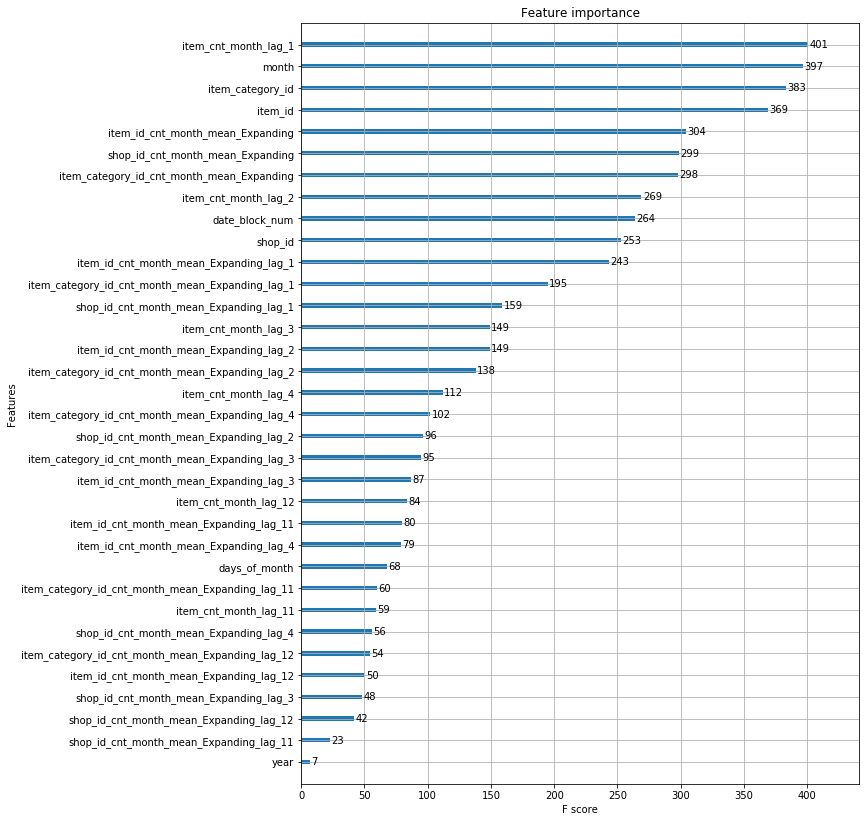

In [33]:
def plot_features(model, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=model, ax=ax)
plot_features(model_xgb, (10,14))

In [34]:
filename = 'finalXGB_model.sav'
pickle.dump(model_xgb, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

## CONCLUSIONS

* A baseline (Stupid Model) was set, providing all target values (item_cnt_month) as **zeros**. This result submited to kaggle for the blind test gave an RMSE of **1.25011**
* A first model was used with a simple **Linear Regression**, obtaining an RMSE of 0.5943 for the validation set, but for the test set confirmed by kaggle it gave **1.1468**. Clearly defining an overfit model, which was latter resolved by a second ensemble model
* A bossting method was determined to be more appropiate for the data, and **XGBoost** was used to obtained a final Best RMSE of 0.72542, for the validation set, and for the test set in kaggle of **1.04212** which reduced a bit the problem of overfitting.
* The most important features relevant for the best model are: item_cnt_lag1, month, item_category_id, item_id and the mean expanding encoding for item_id, shop_id and category_id

The Final ranking acvhieved was **4752 out of 9106** which is not bad for various attempts but the gap of improvement, although is narrow, can get better with further feature engineering (category_label_encodings, popularity of items, more ensemble methods with meta data, etc).